# Análisis Exploratorio de Datos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from prophet.diagnostics import cross_validation
from IPython.display import FileLink

In [2]:
# Cargar el dataset desde tu ubicación
file_path = r"D:\Python\Proyectos\1. Superstore Dataset – Kaggle\Sample - Superstore.csv"
df = pd.read_csv(file_path, encoding='ISO-8859-1')

In [3]:
# Mostrar las primeras filas del DataFrame
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [4]:
# Convertir 'Order Date' y 'Ship Date' a datetime
df['Order Date'] = pd.to_datetime(df['Order Date'], errors='coerce')
df['Ship Date'] = pd.to_datetime(df['Ship Date'], errors='coerce')

# Confirmar conversión
print(df[['Order Date', 'Ship Date']].head())

  Order Date  Ship Date
0 2016-11-08 2016-11-11
1 2016-11-08 2016-11-11
2 2016-06-12 2016-06-16
3 2015-10-11 2015-10-18
4 2015-10-11 2015-10-18


In [5]:
# Verificar valores nulos
df.isnull().sum()

Row ID           0
Order ID         0
Order Date       0
Ship Date        0
Ship Mode        0
Customer ID      0
Customer Name    0
Segment          0
Country          0
City             0
State            0
Postal Code      0
Region           0
Product ID       0
Category         0
Sub-Category     0
Product Name     0
Sales            0
Quantity         0
Discount         0
Profit           0
dtype: int64

In [6]:
# Eliminar filas duplicadas
df = df.drop_duplicates()

In [7]:
df.describe()

,Row ID,Order Date,Ship Date,Postal Code,Sales,Quantity,Discount,Profit
count,9994.000000,9994,9994,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000
mean,4997.500000,2016-04-30 00:07:12.259355648,2016-05-03 23:06:58.571142912,55190.379428,229.858001,3.789574,0.156203,28.656896
min,1.000000,2014-01-03 00:00:00,2014-01-07 00:00:00,1040.000000,0.444000,1.000000,0.000000,-6599.978000
25%,2499.250000,2015-05-23 00:00:00,2015-05-27 00:00:00,23223.000000,17.280000,2.000000,0.000000,1.728750
50%,4997.500000,2016-06-26 00:00:00,2016-06-29 00:00:00,56430.500000,54.490000,3.000000,0.200000,8.666500
75%,7495.750000,2017-05-14 00:00:00,2017-05-18 00:00:00,90008.000000,209.940000,5.000000,0.200000,29.364000
max,9994.000000,2017-12-30 00:00:00,2018-01-05 00:00:00,99301.000000,22638.480000,14.000000,0.800000,8399.976000
std,2885.163629,NaN,NaN,32063.693350,623.245101,2.225110,0.206452,234.260108


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Row ID         9994 non-null   int64         
 1   Order ID       9994 non-null   object        
 2   Order Date     9994 non-null   datetime64[ns]
 3   Ship Date      9994 non-null   datetime64[ns]
 4   Ship Mode      9994 non-null   object        
 5   Customer ID    9994 non-null   object        
 6   Customer Name  9994 non-null   object        
 7   Segment        9994 non-null   object        
 8   Country        9994 non-null   object        
 9   City           9994 non-null   object        
 10  State          9994 non-null   object        
 11  Postal Code    9994 non-null   int64         
 12  Region         9994 non-null   object        
 13  Product ID     9994 non-null   object        
 14  Category       9994 non-null   object        
 15  Sub-Category   9994 n

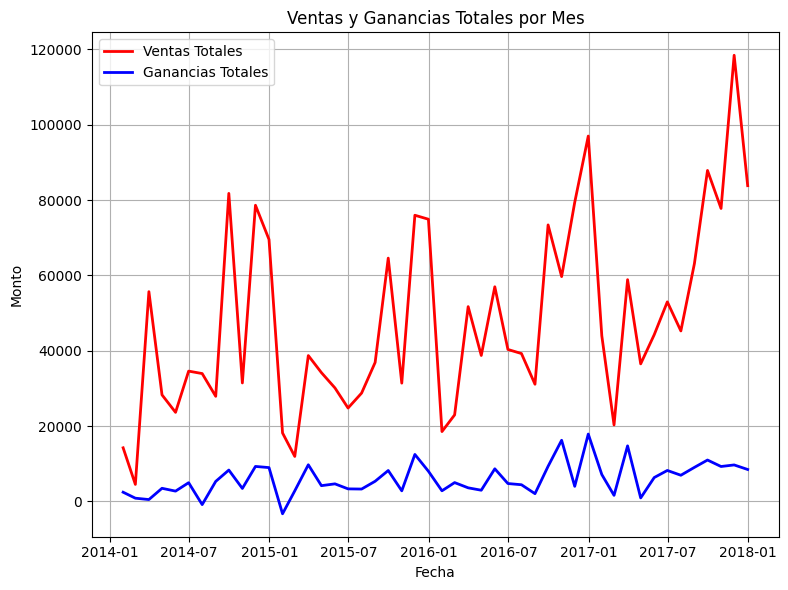

In [9]:
# Análisis Temporal - Ventas a lo largo del tiempo
# Análisis de Rentabilidad - Tendencia de las ganancias en el tiempo
# Crear un gráfico combinado para Ventas y Ganancias Totales por Mes
plt.figure(figsize=(8, 6))

# Resampleo de datos para ventas y ganancias
ventas_mensuales = df.set_index('Order Date')['Sales'].resample('ME').sum()
ganancias_mensuales = df.set_index('Order Date')['Profit'].resample('ME').sum()

# Graficar ambas líneas en el mismo gráfico
plt.plot(ventas_mensuales, label='Ventas Totales', color='red', linewidth=2)
plt.plot(ganancias_mensuales, label='Ganancias Totales', color='blue', linewidth=2)

# Configuración del gráfico
plt.title("Ventas y Ganancias Totales por Mes")
plt.xlabel("Fecha")
plt.ylabel("Monto")
plt.legend()
plt.grid()
plt.tight_layout()

# Mostrar el gráfico
plt.show()

Análisis Temporal de Ventas

Observación: 

- Las ventas fluctúan considerablemente a lo largo del tiempo, con picos de ventas más altos en ciertos meses. Especialmente, al final del año (posible temporada alta de compras).

Decisión: 

- Identificar meses de alto rendimiento para alinear estrategias de marketing y promociones.

Análisis de Rentabilidad

Observación: 
- Las ganancias siguen un patrón más errático, con algunos meses registrando pérdidas. Esto puede deberse a descuentos excesivos o productos no rentables.

Decisión:

- Realizar un análisis detallado de productos y regiones con pérdidas recurrentes.

- Optimizar la política de descuentos y eliminar productos con márgenes bajos.

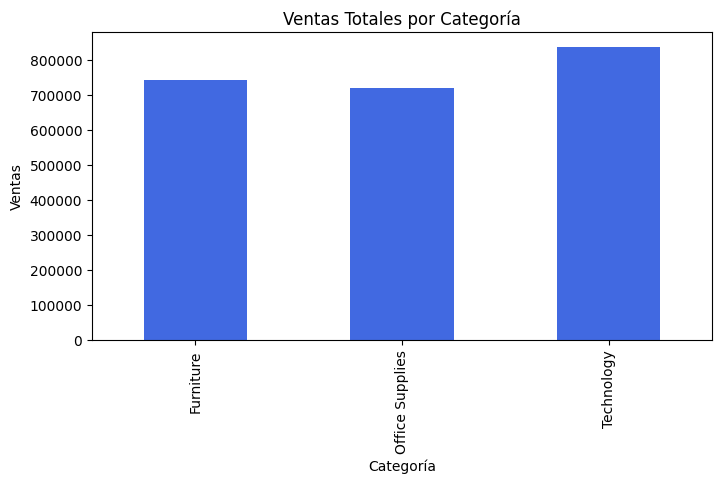

In [10]:
# Agrupación de Ventas por Segmentos - Identificar las ventas por categoría o región
sales_by_category = df.groupby('Category')['Sales'].sum()
sales_by_category.plot(kind='bar', color='royalblue', figsize=(8, 4))
plt.title("Ventas Totales por Categoría")
plt.xlabel("Categoría")
plt.ylabel("Ventas")
plt.show()

Ventas por Categoría:

Observación: 

- La categoría Technology lidera en ventas, mientras que Office Supplies y Furniture están cercanas.

Decisión:

- Fomentar productos de Tecnología con mayor inversión en marketing.

- Analizar los márgenes de ganancias para Furniture y Office Supplies y realizar promociones en productos más rentables.

In [11]:
# Guardar Resultados como CSV
df.to_csv("superstore_limpio.csv", index=False)
print("Archivo guardado exitosamente.")

Archivo guardado exitosamente.


In [12]:
# Relación entre Descuentos y Rentabilidad
# Agrupar datos por rango de descuento y calcular estadísticas clave
df['Discount_Range'] = pd.cut(df['Discount'], bins=[0, 0.1, 0.2, 0.3, 0.5, 0.8], 
                              labels=['0-10%', '10-20%', '20-30%', '30-50%', '50-80%'])

# Especificar observed=False para silenciar el warning
discount_analysis = df.groupby('Discount_Range', observed=False).agg({
    'Profit': ['sum', 'mean'], 
    'Sales': 'sum', 
    'Discount': 'count'
})

# Renombrar columnas
discount_analysis.columns = ['Total_Profit', 'Average_Profit', 'Total_Sales', 'Count']
discount_analysis['Avg_Discount'] = discount_analysis.index

# Mostrar resultados
print(discount_analysis)

                Total_Profit  Average_Profit  Total_Sales  Count Avg_Discount
Discount_Range                                                               
0-10%              9029.1770       96.055074   54369.3510     94        0-10%
10-20%            91756.2975       24.738824  792152.8895   3709       10-20%
20-30%           -10369.2774      -45.679636  103226.6550    227       20-30%
30-50%           -48447.7273     -156.282991  195314.7568    310       30-50%
50-80%           -76559.0513      -89.438144   64228.7380    856       50-80%


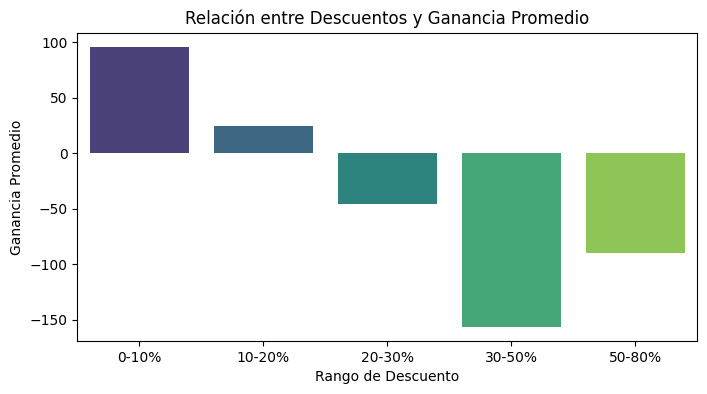

In [13]:
# Visualizar relación con un gráfico
plt.figure(figsize=(8, 4))
sns.barplot(x=discount_analysis.index, y=discount_analysis['Average_Profit'], 
            palette='viridis', hue=discount_analysis.index, legend=False)
plt.title("Relación entre Descuentos y Ganancia Promedio")
plt.xlabel("Rango de Descuento")
plt.ylabel("Ganancia Promedio")
plt.show()

Conclusión:

- Descuentos bajos (0-10%) generan una ganancia promedio positiva significativa.

- Descuentos entre 10-20% todavía generan beneficios, aunque reducidos.

- Descuentos superiores al 20% (30-50% y 50-80%) conducen a pérdidas importantes, mostrando que los descuentos agresivos tienen un impacto negativo en la rentabilidad.

Productos con altos descuentos y pérdidas:
                                                    Discount     Profit  \
Product Name                                                              
Cubify CubeX 3D Printer Double Head Print           0.700000 -9239.9692   
GBC DocuBind P400 Electric Binding System           0.766667 -6859.3896   
Lexmark MX611dhe Monochrome Laser Printer           0.500000 -5269.9690   
GBC Ibimaster 500 Manual ProClick Binding System    0.716667 -5098.5660   
GBC DocuBind TL300 Electric Binding System          0.725000 -4162.0336   
Cubify CubeX 3D Printer Triple Head Print           0.500000 -3839.9904   
Fellowes PB500 Electric Punch Plastic Comb Bind...  0.800000 -3431.6730   
Chromcraft Bull-Nose Wood Oval Conference Table...  0.400000 -3008.3508   
Ibico EPK-21 Electric Binding System                0.800000 -2929.4845   
Bush Advantage Collection Racetrack Conference ...  0.430000 -2392.5444   

                                                        

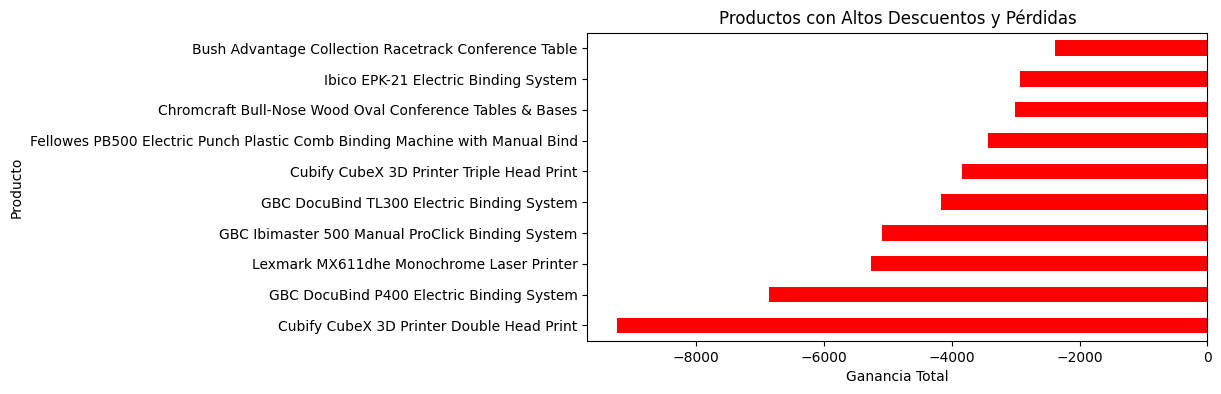

In [14]:
# Productos con Altos Descuentos y Pérdidas
# Filtrar productos con alta pérdida y altos descuentos
high_discount_loss = df[(df['Discount'] > 0.3) & (df['Profit'] < 0)].groupby('Product Name').agg({
    'Discount': 'mean', 'Profit': 'sum', 'Sales': 'sum'
}).sort_values(by='Profit', ascending=True)

print("Productos con altos descuentos y pérdidas:")
print(high_discount_loss.head(10))

# Visualización
plt.figure(figsize=(8, 4))
high_discount_loss['Profit'].head(10).plot(kind='barh', color='red')
plt.title("Productos con Altos Descuentos y Pérdidas")
plt.xlabel("Ganancia Total")
plt.ylabel("Producto")
plt.show()

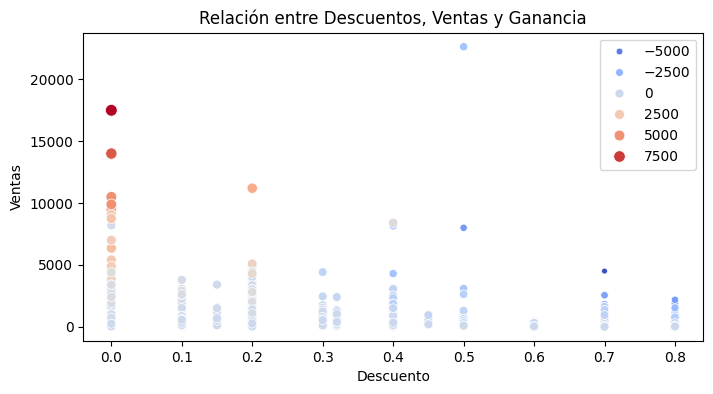

In [15]:
# Impacto del Descuento en Ventas
# Relación entre descuento y ventas
plt.figure(figsize=(8, 4))
sns.scatterplot(data=df, x='Discount', y='Sales', hue='Profit', palette='coolwarm', size='Profit')
plt.title("Relación entre Descuentos, Ventas y Ganancia")
plt.xlabel("Descuento")
plt.ylabel("Ventas")
plt.legend()
plt.show()

Conclusión:

- Descuentos bajos generan ventas consistentes con ganancias positivas.

- Descuentos más altos resultan en un aumento en ventas, pero las ganancias se vuelven negativas.

- Es importante optimizar los niveles de descuento para mantener un equilibrio entre ventas y rentabilidad.

In [16]:
# Gráfico de barras - Relación entre Descuentos y Ganancias Totales
plt.figure(figsize=(8, 4))
discount_analysis['Total_Profit'].plot(kind='bar', color=colores)
colores = plt.cm.inferno(np.linspace(0, 1, len(discount_analysis)))
# Configuración del gráfico
plt.title("Relación entre Descuentos y Rentabilidad")
plt.xlabel("Rango de Descuento")
plt.ylabel("Ganancia Total")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

NameError: name 'colores' is not defined

<Figure size 800x400 with 0 Axes>

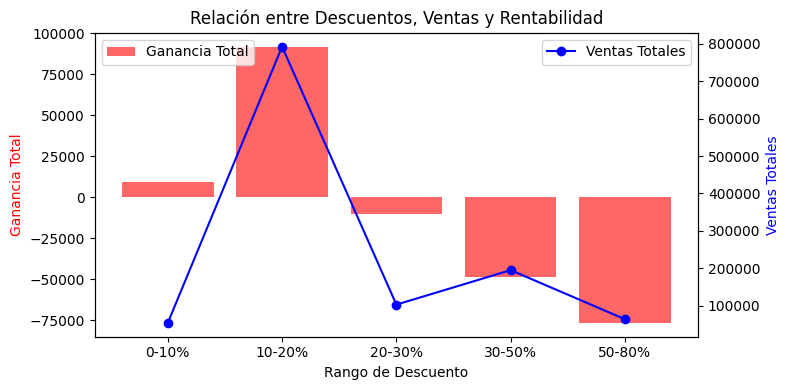

In [66]:
# Ganancia Total y las Ventas Totales por Rango de Descuento
# Gráfico combinado: Ganancia Total y Ventas Totales
fig, ax1 = plt.subplots(figsize=(8, 4))

# Barra: Ganancia Total
ax1.bar(discount_analysis['Avg_Discount'], discount_analysis['Total_Profit'], color='red', alpha=0.6, label='Ganancia Total')

# Línea: Ventas Totales
ax2 = ax1.twinx()
ax2.plot(discount_analysis['Avg_Discount'], discount_analysis['Total_Sales'], color='blue', marker='o', label='Ventas Totales')

# Configuración de etiquetas
ax1.set_xlabel("Rango de Descuento")
ax1.set_ylabel("Ganancia Total", color='red')
ax2.set_ylabel("Ventas Totales", color='blue')
plt.title("Relación entre Descuentos, Ventas y Rentabilidad")
fig.tight_layout()

# Leyenda
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

# Mostrar gráfico
plt.show()

Conclusión:

- Aunque los descuentos agresivos pueden aumentar las ventas, estos no son suficientes para generar ganancias.

- Se deben analizar y ajustar las estrategias de descuento para evitar comprometer la rentabilidad.

In [67]:
# Análisis de Ventas por Ciudad y Región
# Análisis de Ventas por Región
sales_by_region = df.groupby('Region')['Sales'].sum().sort_values(ascending=False)
print("Ventas Totales por Región:")
print(sales_by_region)

Ventas Totales por Región:
Region
West       725457.8245
East       678781.2400
Central    501239.8908
South      391721.9050
Name: Sales, dtype: float64


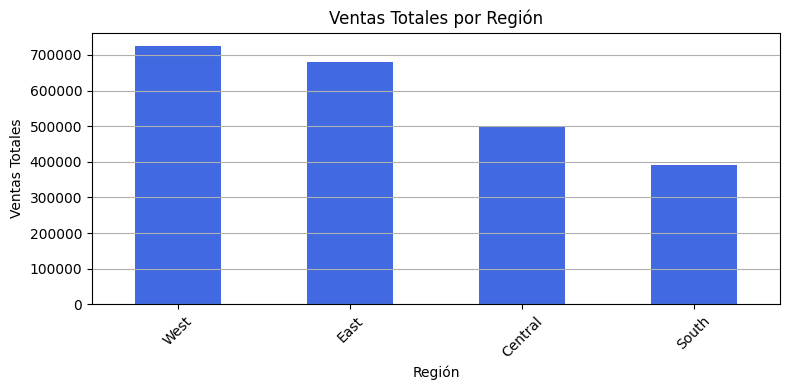

In [ ]:
# Visualización: Ventas Totales por Región
plt.figure(figsize=(8, 4))
sales_by_region.plot(kind='bar', color='royalblue')
plt.title("Ventas Totales por Región")
plt.xlabel("Región")
plt.ylabel("Ventas Totales")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

Conclusión:

- Se debería analizar por qué la región West supera en ventas, considerando estrategias implementadas, demanda y posibles factores regionales.

- Las regiones Central y South requieren atención para identificar oportunidades de crecimiento, como estrategias de marketing más enfocadas o mejor distribución de productos.

In [69]:
# Análisis de Ventas por Ciudad
top_cities = df.groupby('City')['Sales'].sum().sort_values(ascending=False).head(10)
print("Top 10 Ciudades con más Ventas:")
print(top_cities)

Top 10 Ciudades con más Ventas:
City
New York City    256368.1610
Los Angeles      175851.3410
Seattle          119540.7420
San Francisco    112669.0920
Philadelphia     109077.0130
Houston           64504.7604
Chicago           48539.5410
San Diego         47521.0290
Jacksonville      44713.1830
Springfield       43054.3420
Name: Sales, dtype: float64


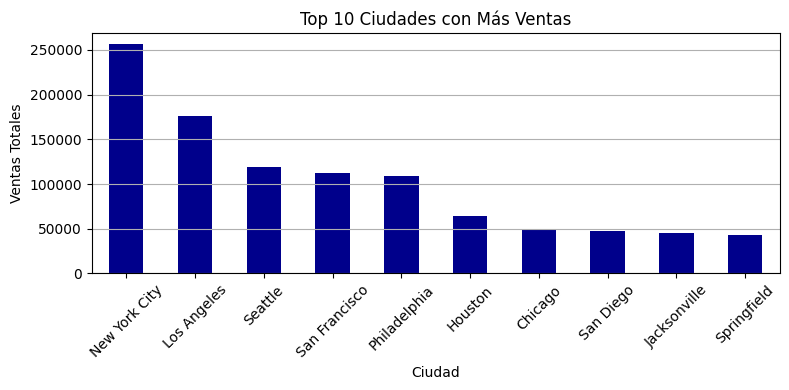

In [78]:
# Visualización: Top 10 Ciudades con más Ventas
plt.figure(figsize=(8, 4))
top_cities.plot(kind='bar', color='darkblue')
plt.title("Top 10 Ciudades con Más Ventas")
plt.xlabel("Ciudad")
plt.ylabel("Ventas Totales")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

Conclusión:

- Las ciudades grandes como New York City y Los Angeles son centros económicos importantes, contribuyendo significativamente a las ventas totales.

- Es recomendable fortalecer la presencia en estas ciudades, mientras que ciudades con menor volumen dentro del top 10 podrían tener espacio para más crecimiento.

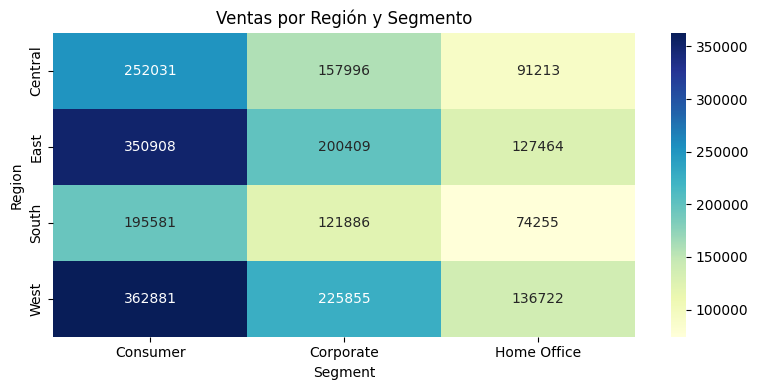

In [ ]:
# Mapa de Calor: Ventas por Región y Segmento
heatmap_data = df.pivot_table(values='Sales', index='Region', columns='Segment', aggfunc='sum')

plt.figure(figsize=(8, 4))
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', fmt=".0f")
plt.title("Ventas por Región y Segmento")
plt.tight_layout()
plt.show()

Conclusión:

- El segmento Consumer es clave en todas las regiones y debería mantenerse como prioridad estratégica.

- El segmento Corporate también tiene un potencial considerable, especialmente en las regiones West y East.

- El segmento Home Office necesita estrategias específicas para aumentar su participación, posiblemente explorando promociones y nuevos canales de venta.

In [73]:
# Realizar el Análisis de Microsegmentación
# Agrupar ciudades con métricas clave
microsegment = df.groupby(['Region', 'City']).agg({
    'Sales': 'sum',
    'Profit': 'sum',
    'Discount': 'mean',
    'Order ID': 'count'
}).rename(columns={'Order ID': 'Transactions'}).reset_index()

# Filtrar ciudades con ventas y ganancias bajas
underperforming_cities = microsegment[(microsegment['Sales'] < 50000) & (microsegment['Profit'] < 5000)]
print(underperforming_cities.head())

    Region       City      Sales    Profit  Discount  Transactions
0  Central   Aberdeen    25.5000    6.6300     0.000             1
1  Central    Abilene     1.3920   -3.7584     0.800             1
2  Central      Allen   290.2060  -39.8775     0.375             4
3  Central   Amarillo  3773.0628 -387.9683     0.272            10
4  Central  Ann Arbor   889.2730  228.9158     0.020             5


In [84]:
# Clasificación por Métricas de Desempeño
microsegment['Performance'] = np.where(
    (microsegment['Sales'] < 50000) & (microsegment['Profit'] < 5000), 'Bajo Desempeño', 'Normal'
)
print(microsegment.head())

    Region       City      Sales    Profit  Discount  Transactions  \
0  Central   Aberdeen    25.5000    6.6300     0.000             1   
1  Central    Abilene     1.3920   -3.7584     0.800             1   
2  Central      Allen   290.2060  -39.8775     0.375             4   
3  Central   Amarillo  3773.0628 -387.9683     0.272            10   
4  Central  Ann Arbor   889.2730  228.9158     0.020             5   

      Performance  
0  Bajo Desempeño  
1  Bajo Desempeño  
2  Bajo Desempeño  
3  Bajo Desempeño  
4  Bajo Desempeño  


In [82]:
# Problema Posible: Umbrales Mal Definidos
print(microsegment[['Sales', 'Profit']].describe())

               Sales        Profit
count     583.000000    583.000000
mean     3940.310223    491.247036
std     15996.890439   3500.377426
min         1.392000 -13837.767400
25%       241.938000      3.197400
50%       915.088000     73.352900
75%      2794.432000    364.405950
max    256368.161000  62036.983700


In [83]:
microsegment['Performance'] = np.where(
    (microsegment['Sales'] < 20000) & (microsegment['Profit'] < 1000), 'Bajo Desempeño', 'Normal'
)

In [85]:
conditions = [
    (microsegment['Sales'] < 20000) & (microsegment['Profit'] < 1000),
    (microsegment['Sales'] >= 20000) & (microsegment['Profit'] >= 1000),
    (microsegment['Sales'] > 50000) & (microsegment['Profit'] > 5000)
]

choices = ['Bajo Desempeño', 'Normal', 'Alto Desempeño']

microsegment['Performance'] = np.select(conditions, choices, default='Normal')
print(microsegment.head())

    Region       City      Sales    Profit  Discount  Transactions  \
0  Central   Aberdeen    25.5000    6.6300     0.000             1   
1  Central    Abilene     1.3920   -3.7584     0.800             1   
2  Central      Allen   290.2060  -39.8775     0.375             4   
3  Central   Amarillo  3773.0628 -387.9683     0.272            10   
4  Central  Ann Arbor   889.2730  228.9158     0.020             5   

      Performance  
0  Bajo Desempeño  
1  Bajo Desempeño  
2  Bajo Desempeño  
3  Bajo Desempeño  
4  Bajo Desempeño  


In [86]:
Q1 = microsegment['Sales'].quantile(0.25)
Q3 = microsegment['Sales'].quantile(0.75)
IQR = Q3 - Q1

# Filtrar valores atípicos
filtered_microsegment = microsegment[(microsegment['Sales'] >= Q1 - 1.5*IQR) & (microsegment['Sales'] <= Q3 + 1.5*IQR)]

In [87]:
print(microsegment['Performance'].value_counts())

Performance
Bajo Desempeño    506
Normal             77
Name: count, dtype: int64


In [88]:
# Ajuste de Condiciones
conditions = [
    (microsegment['Sales'] < 2000) & (microsegment['Profit'] < 200),
    ((microsegment['Sales'] >= 2000) & (microsegment['Sales'] <= 10000)) &
    ((microsegment['Profit'] >= 200) & (microsegment['Profit'] <= 5000)),
    (microsegment['Sales'] > 10000) & (microsegment['Profit'] > 5000)
]

choices = ['Bajo Desempeño', 'Normal', 'Alto Desempeño']

microsegment['Performance'] = np.select(conditions, choices, default='Normal')
print(microsegment['Performance'].value_counts())

Performance
Bajo Desempeño    330
Normal            241
Alto Desempeño     12
Name: count, dtype: int64


In [ ]:
# Filtrar valores atípicos en 'Sales' usando IQR
Q1 = microsegment['Sales'].quantile(0.25)
Q3 = microsegment['Sales'].quantile(0.75)
IQR = Q3 - Q1

# Filtrar atípicos y crear copia explícita
filtered_microsegment = microsegment[
    (microsegment['Sales'] >= Q1 - 1.5 * IQR) & (microsegment['Sales'] <= Q3 + 1.5 * IQR)
].copy()

# Verificar si hay datos en el subconjunto filtrado
print(f"Cantidad de registros filtrados: {len(filtered_microsegment)}")
print(filtered_microsegment[['Sales', 'Profit']].describe())

# Recalcular las condiciones para el subconjunto filtrado
conditions_filtered = [
    (filtered_microsegment['Sales'] < 2000) & (filtered_microsegment['Profit'] < 200),
    ((filtered_microsegment['Sales'] >= 2000) & (filtered_microsegment['Sales'] <= 10000)) &
    ((filtered_microsegment['Profit'] >= 200) & (filtered_microsegment['Profit'] <= 5000)),
    (filtered_microsegment['Sales'] > 10000) & (filtered_microsegment['Profit'] > 5000)
]

choices = ['Bajo Desempeño', 'Normal', 'Alto Desempeño']

# Aplicar las condiciones
filtered_microsegment['Performance'] = np.select(conditions_filtered, choices, default='Normal')

# Mostrar resultados
print("Distribución de Performance en el subconjunto filtrado:")
print(filtered_microsegment['Performance'].value_counts())
print(filtered_microsegment.head())

Cantidad de registros filtrados: 529
             Sales       Profit
count   529.000000   529.000000
mean   1410.200540   162.072366
std    1646.205866   494.529187
min       1.392000 -3406.209500
25%     212.910000     3.354400
50%     790.972000    62.251800
75%    1944.246000   282.440500
max    6602.706400  2293.682800
Distribución de Performance en el subconjunto filtrado:
Performance
Bajo Desempeño    330
Normal            199
Name: count, dtype: int64
    Region       City      Sales    Profit  Discount  Transactions  \
0  Central   Aberdeen    25.5000    6.6300     0.000             1   
1  Central    Abilene     1.3920   -3.7584     0.800             1   
2  Central      Allen   290.2060  -39.8775     0.375             4   
3  Central   Amarillo  3773.0628 -387.9683     0.272            10   
4  Central  Ann Arbor   889.2730  228.9158     0.020             5   

      Performance  
0  Bajo Desempeño  
1  Bajo Desempeño  
2  Bajo Desempeño  
3          Normal  
4          Norma

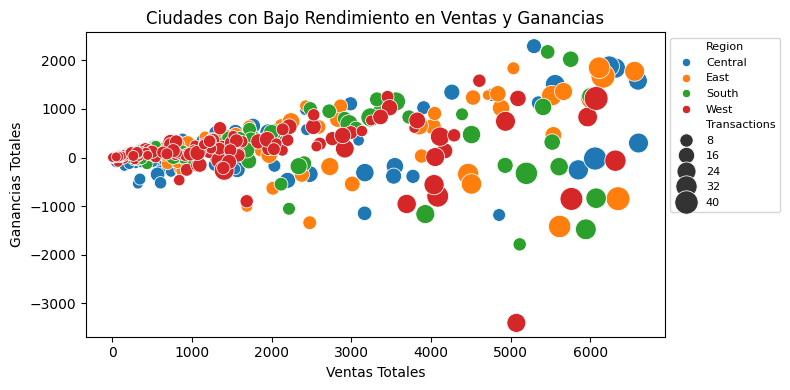

In [107]:
# Definir colores específicos para cada región
region_colors = {
    'Central': '#1f77b4',  # Azul
    'East': '#ff7f0e',     # Naranja
    'South': '#2ca02c',    # Verde
    'West': '#d62728'      # Rojo
}

# Visualización de Microsegmentos
plt.figure(figsize=(8, 4))
sns.scatterplot(
    data=filtered_microsegment, 
    x='Sales', 
    y='Profit', 
    hue='Region', 
    size='Transactions', 
    sizes=(50, 300), 
    palette=region_colors  # Paleta manual definida
)
plt.title("Ciudades con Bajo Rendimiento en Ventas y Ganancias")
plt.xlabel("Ventas Totales")
plt.ylabel("Ganancias Totales")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=8)
plt.tight_layout()
plt.show()

In [80]:
# Análisis de Categorías y Segmentos
# Filtrar por ciudad específica
city_analysis = df[df['City'].isin(underperforming_cities['City'])]
category_sales = city_analysis.groupby(['City', 'Category']).agg({'Sales': 'sum', 'Profit': 'sum'})
print(category_sales)

                             Sales    Profit
City     Category                           
Aberdeen Office Supplies    25.500    6.6300
Abilene  Office Supplies     1.392   -3.7584
Akron    Furniture         433.596  -72.0996
         Office Supplies  1113.388   22.3152
         Technology       1183.002 -136.8512
...                            ...       ...
York     Furniture         422.058  -18.0882
         Office Supplies   395.920  -84.0810
Yucaipa  Office Supplies    50.800   13.2080
Yuma     Office Supplies    55.352  -34.7040
         Technology        785.513 -431.2869

[1162 rows x 2 columns]


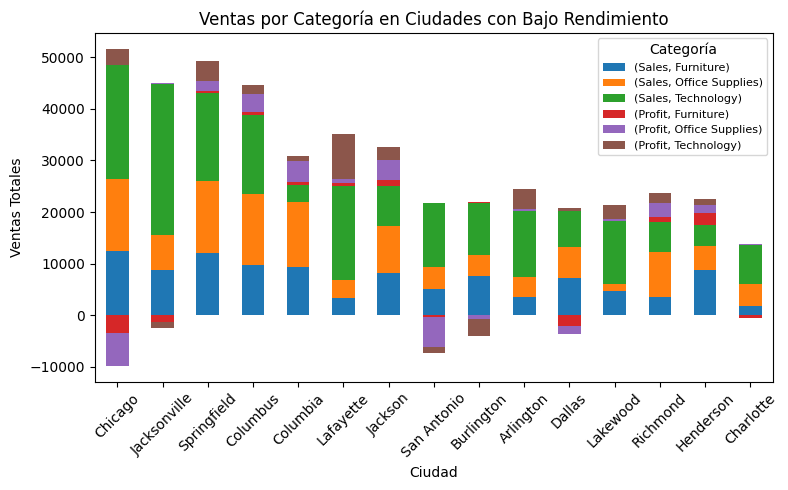

In [106]:
# Mostrar solo el Top 15 ciudades
top_cities_sales = category_sales.groupby(level=0)['Sales'].sum().nlargest(15).index
filtered_category_sales = category_sales.loc[top_cities_sales]

# Visualización del gráfico
filtered_category_sales.unstack().plot(kind='bar', stacked=True, figsize=(8, 5))
plt.title("Ventas por Categoría en Ciudades con Bajo Rendimiento")
plt.xlabel("Ciudad")
plt.ylabel("Ventas Totales")
plt.xticks(rotation=45)

# Configurar leyenda más pequeña y en la esquina superior derecha
plt.legend(title="Categoría", fontsize=8, loc='upper right', bbox_to_anchor=(1, 1), frameon=True)

plt.tight_layout()
plt.show()

In [108]:
# Analizar la Elasticidad Precio-Demanda para identificar productos sensibles a descuentos excesivos
# Filtrar productos con descuentos
discounted_products = df[df['Discount'] > 0]

# Calcular elasticidad precio-demanda por producto
product_elasticity = (
    discounted_products.groupby('Product ID')
    .agg({'Sales': 'sum', 'Quantity': 'sum', 'Discount': 'mean', 'Profit': 'sum'})
    .reset_index()
)


In [109]:
# Cálculo de elasticidad aproximada
product_elasticity['Elasticity'] = (product_elasticity['Quantity'].pct_change() /
                                    product_elasticity['Discount'].pct_change())

In [110]:
# Identificar productos sensibles a descuentos
product_elasticity['Sensitivity'] = np.where(product_elasticity['Elasticity'] < -1, 'Alta Sensibilidad', 'Baja Sensibilidad')

           Product ID     Sales  Quantity  Discount   Profit  Elasticity  \
436   OFF-AR-10000246     8.896         4       0.2   0.6672        -inf   
1269  OFF-ST-10004963    60.560         5       0.2 -12.1120        -inf   
1143  OFF-PA-10004983    31.104         6       0.2  10.8864        -inf   
1146  OFF-ST-10000036   474.192         6       0.2  41.4918        -inf   
1149  OFF-ST-10000078  1909.224         9       0.2 -47.7306        -inf   
1151  OFF-ST-10000129   177.648         2       0.2 -28.8678        -inf   
1153  OFF-ST-10000142   998.112         3       0.2  99.8112        -inf   
1361  TEC-AC-10002345    58.000         5       0.2   3.6250        -inf   
1363  TEC-AC-10002380    27.192         3       0.2   0.3399        -inf   
1367  TEC-AC-10002550   332.136        15       0.2 -36.7677        -inf   

            Sensitivity  
436   Alta Sensibilidad  
1269  Alta Sensibilidad  
1143  Alta Sensibilidad  
1146  Alta Sensibilidad  
1149  Alta Sensibilidad  
1151  A

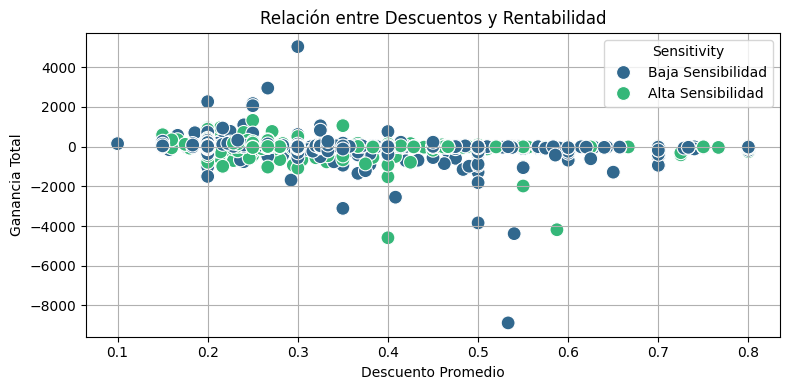

In [ ]:
# Mostrar resultados
print(product_elasticity.sort_values(by='Elasticity', ascending=True).head(10))

# Visualizar relación entre descuento y rentabilidad
plt.figure(figsize=(8, 4))
sns.scatterplot(data=product_elasticity, x='Discount', y='Profit', hue='Sensitivity', palette='viridis', s=100)
plt.title("Relación entre Descuentos y Rentabilidad")
plt.xlabel("Descuento Promedio")
plt.ylabel("Ganancia Total")
plt.grid()
plt.tight_layout()
plt.show()

In [113]:
# Implementación de Pruebas A/B para Estrategias de Descuento
# Selección del Subconjunto de Productos Clave
# Filtrar productos con descuentos altos (>30%) y ganancias negativas
key_products = df[(df['Discount'] > 0.3) & (df['Profit'] < 0)].groupby('Product Name').agg({
    'Sales': 'sum',
    'Discount': 'mean',
    'Profit': 'sum'
}).reset_index()

# Mostrar los productos clave
print("Productos Clave para Pruebas A/B:")
print(key_products.head())

Productos Clave para Pruebas A/B:
                                        Product Name     Sales  Discount  \
0                   12-1/2 Diameter Round Wall Clock    87.912       0.6   
1  3.6 Cubic Foot Counter Height Office Refrigerator   530.316       0.8   
2                           36X48 HARDFLOOR CHAIRMAT    41.960       0.6   
3     3D Systems Cube Printer, 2nd Generation, White  1299.990       0.5   
4                   3M Hangers With Command Adhesive     2.960       0.6   

      Profit  
0   -52.7472  
1 -1378.8216  
2   -55.5970  
3  -571.9956  
4    -1.4060  


In [114]:
# Creación de Grupos A/B
from sklearn.model_selection import train_test_split

# División en dos grupos
group_a, group_b = train_test_split(key_products, test_size=0.5, random_state=42)

# Asignar nuevas políticas de descuento
group_a['New_Discount'] = 0.1  # Descuento reducido al 10%
group_b['New_Discount'] = group_b['Discount'] * 0.7  # Reducción del 30% en el descuento original

# Mostrar los grupos
print("Grupo A (Descuento Reducido):")
print(group_a.head())

print("Grupo B (Descuento Diferenciado):")
print(group_b.head())

Grupo A (Descuento Reducido):
                                          Product Name     Sales  Discount  \
36   Acco Recycled 2" Capacity Laser Printer Hangin...   15.8950  0.750000   
139                         Cardinal Hold-It CD Pocket   12.7680  0.800000   
253          GBC DocuBind P50 Personal Binding Machine  307.1040  0.700000   
321  Hon Practical Foundations 30 x 60 Training Tab...  785.0475  0.425000   
59   Avery Binding System Hidden Tab Executive Styl...   14.4250  0.766667   

       Profit  New_Discount  
36   -14.7390           0.1  
139  -21.0672           0.1  
253 -235.4464           0.1  
321 -279.8865           0.1  
59   -17.3100           0.1  
Grupo B (Descuento Diferenciado):
                                          Product Name    Sales  Discount  \
316                             Hon 4060 Series Tables   67.176  0.400000   
77   Avery Premier Heavy-Duty Binder with Round Loc...   17.136  0.800000   
360      JBL Micro Wireless Portable Bluetooth Speaker  

In [115]:
# Simulación de Ventas y Ganancias
# Definir elasticidad promedio (suposición basada en análisis previos)
elasticity = -1.5

# Calcular ventas y ganancias para cada grupo
def simulate_performance(group):
    group['Price_Reduction'] = group['New_Discount'] - group['Discount']
    group['New_Sales'] = group['Sales'] * (1 + elasticity * group['Price_Reduction'])
    group['New_Profit'] = group['New_Sales'] - (group['Sales'] * 0.8)  # Suposición: costo del 80% de ventas
    return group

group_a = simulate_performance(group_a)
group_b = simulate_performance(group_b)

# Comparar resultados
print("Resultados Simulados - Grupo A:")
print(group_a[['Product Name', 'Sales', 'New_Sales', 'Profit', 'New_Profit']].head())

print("Resultados Simulados - Grupo B:")
print(group_b[['Product Name', 'Sales', 'New_Sales', 'Profit', 'New_Profit']].head())

Resultados Simulados - Grupo A:
                                          Product Name     Sales    New_Sales  \
36   Acco Recycled 2" Capacity Laser Printer Hangin...   15.8950    31.392625   
139                         Cardinal Hold-It CD Pocket   12.7680    26.174400   
253          GBC DocuBind P50 Personal Binding Machine  307.1040   583.497600   
321  Hon Practical Foundations 30 x 60 Training Tab...  785.0475  1167.758156   
59   Avery Binding System Hidden Tab Executive Styl...   14.4250    28.850000   

       Profit  New_Profit  
36   -14.7390   18.676625  
139  -21.0672   15.960000  
253 -235.4464  337.814400  
321 -279.8865  539.720156  
59   -17.3100   17.310000  
Resultados Simulados - Grupo B:
                                          Product Name    Sales  New_Sales  \
316                             Hon 4060 Series Tables   67.176   79.26768   
77   Avery Premier Heavy-Duty Binder with Round Loc...   17.136   23.30496   
360      JBL Micro Wireless Portable Bluetooth 

Comparación de Resultados entre Grupo A y Grupo B:
  Grupo  Ventas Totales  Ganancia Total  Cantidad de Productos
0     A   180984.469762    91179.946083                    273
1     B   155149.344533    54333.027573                    273


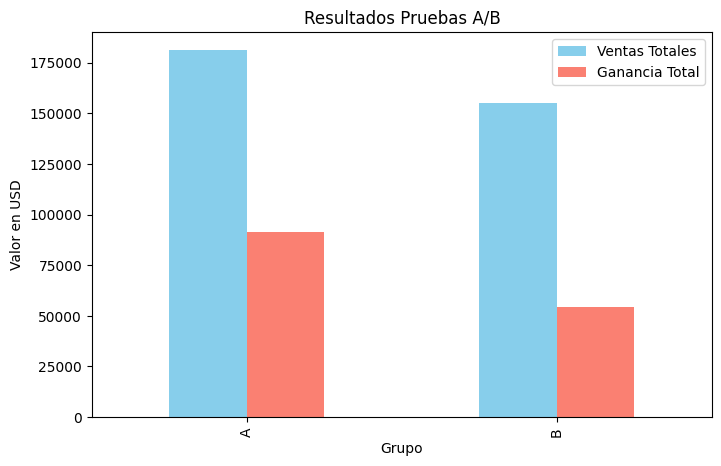

In [116]:
# Análisis de Resultados
# Consolidar resultados
results = pd.DataFrame({
    'Grupo': ['A', 'B'],
    'Ventas Totales': [group_a['New_Sales'].sum(), group_b['New_Sales'].sum()],
    'Ganancia Total': [group_a['New_Profit'].sum(), group_b['New_Profit'].sum()],
    'Cantidad de Productos': [len(group_a), len(group_b)]
})

# Mostrar resultados
print("Comparación de Resultados entre Grupo A y Grupo B:")
print(results)

# Visualizar resultados
results.plot(kind='bar', x='Grupo', y=['Ventas Totales', 'Ganancia Total'], 
             figsize=(8, 5), color=['skyblue', 'salmon'], title="Resultados Pruebas A/B")
plt.ylabel("Valor en USD")
plt.show()

Conclusiones:

Impacto en Ventas Totales:

- El Grupo A logró ventas totales más altas que el Grupo B. Esto sugiere que reducir los descuentos a un nivel fijo (10%) no disminuyó significativamente las ventas, mientras que en el Grupo B, la reducción parcial del descuento podría haber limitado la demanda.

Impacto en Ganancias Totales:

- El Grupo A mostró una ganancia total sustancialmente mayor en comparación al Grupo B (casi el doble). Esto indica que reducir los descuentos excesivos mejora significativamente la rentabilidad.

Elasticidad Precio-Demanda:

- Los productos en Grupo B, con descuentos más diferenciados, podrían ser más sensibles a cambios en precios, lo cual explica el menor impacto positivo en las ganancias.
Por el contrario, en Grupo A, reducir los descuentos fue menos perjudicial para la demanda y resultó en mayor rentabilidad.

Resultados de Pruebas A/B por Categoría:
         Categoría  Ventas_Totales_A  Ganancia_Total_A  Ventas_Totales_B  \
0        Furniture      66007.927948      31028.398028      62171.339236   
1       Technology     108310.322675      54512.283475      43142.396990   
2  Office Supplies      25388.685627      15193.488827      35680.942774   

   Ganancia_Total_B  Cantidad_Productos  
0      20606.556516                 180  
1      14482.425790                 113  
2      14257.621974                 253  


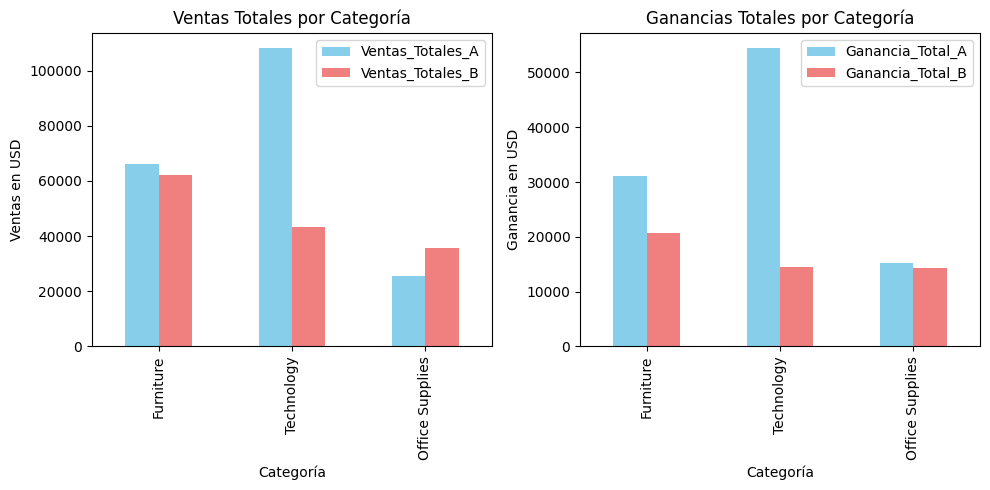

In [127]:
# Pruebas Segmentadas por Categoría
# Segmentación por categoría
categories = ['Furniture', 'Technology', 'Office Supplies']

# Iterar por cada categoría
results_by_category = []
for category in categories:
    # Filtrar productos por categoría con descuentos altos (>30%) y ganancias negativas
    category_products = df[(df['Category'] == category) & (df['Discount'] > 0.3) & (df['Profit'] < 0)]
    
    # Agrupar productos
    key_products = category_products.groupby('Product Name').agg({
        'Sales': 'sum',
        'Discount': 'mean',
        'Profit': 'sum'
    }).reset_index()

    # División en grupos A/B
    group_a, group_b = train_test_split(key_products, test_size=0.5, random_state=42)

    # Asignar políticas de descuento
    group_a['New_Discount'] = 0.1  # Descuento fijo reducido
    group_b['New_Discount'] = group_b['Discount'] * 0.7  # Reducción del 30% en el descuento original

    # Simular desempeño
    group_a = simulate_performance(group_a)
    group_b = simulate_performance(group_b)

    # Guardar resultados
    results_by_category.append({
        'Categoría': category,
        'Ventas_Totales_A': group_a['New_Sales'].sum(),
        'Ganancia_Total_A': group_a['New_Profit'].sum(),
        'Ventas_Totales_B': group_b['New_Sales'].sum(),
        'Ganancia_Total_B': group_b['New_Profit'].sum(),
        'Cantidad_Productos': len(key_products)
    })

# Consolidar resultados
results_df = pd.DataFrame(results_by_category)

# Mostrar resultados
print("Resultados de Pruebas A/B por Categoría:")
print(results_df)

# Visualización de resultados
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Ventas Totales
results_df.plot(kind='bar', x='Categoría', y=['Ventas_Totales_A', 'Ventas_Totales_B'], 
                color=['skyblue', 'lightcoral'], ax=axes[0])
axes[0].set_title("Ventas Totales por Categoría")
axes[0].set_ylabel("Ventas en USD")

# Ganancias Totales
results_df.plot(kind='bar', x='Categoría', y=['Ganancia_Total_A', 'Ganancia_Total_B'], 
                color=['skyblue', 'lightcoral'], ax=axes[1])
axes[1].set_title("Ganancias Totales por Categoría")
axes[1].set_ylabel("Ganancia en USD")

plt.tight_layout()
plt.show()

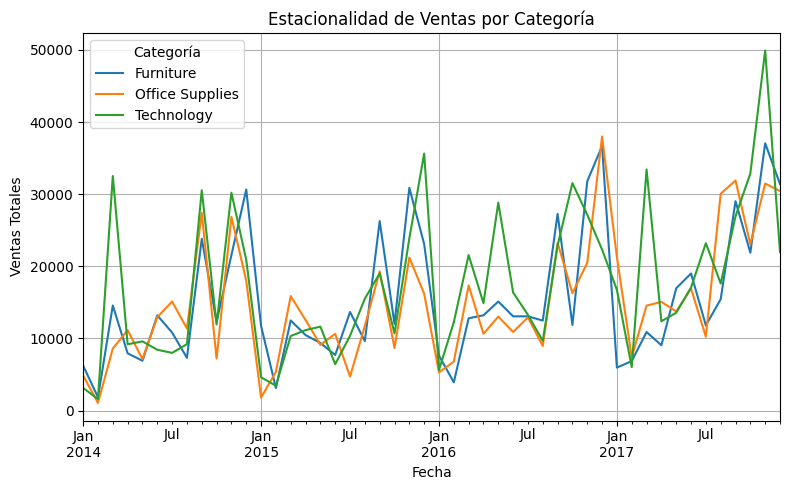

In [125]:
# Análisis de Estacionalidad
# Agrupar por mes y categoría utilizando 'ME'
monthly_sales = df.groupby([pd.Grouper(freq='ME'), 'Category'])['Sales'].sum().unstack()

# Visualización de ventas mensuales por categoría
plt.figure(figsize=(8, 5))
monthly_sales.plot(ax=plt.gca())
plt.title("Estacionalidad de Ventas por Categoría")
plt.xlabel("Fecha")
plt.ylabel("Ventas Totales")
plt.legend(title="Categoría")
plt.grid()
plt.tight_layout()
plt.show()

Análisis de los Resultados de Pruebas A/B por Categoría y Estacionalidad

Resultados Segmentados por Categoría

1. Ventas Totales y Ganancias por Grupo A/B:

     Furniture:

          Grupo A (descuento fijo reducido):
               Ventas Totales: 66,007 USD
               Ganancia Total: 31,028 USD

          Grupo B (descuento diferenciado):
               Ventas Totales: 62,171 USD
               Ganancia Total: 20,606 USD

     Conclusión: El descuento reducido en Grupo A resultó en mayores ganancias totales.
     
     Technology:

          Grupo A (descuento fijo reducido):
               Ventas Totales: 108,310 USD
               Ganancia Total: 54,512 USD

          Grupo B (descuento diferenciado):
               Ventas Totales: 43,142 USD
               Ganancia Total: 14,482 USD
     
     Conclusión: Tecnología responde mejor a descuentos reducidos y fijos, optimizando tanto ventas como ganancias.

     Office Supplies:

          Grupo A (descuento fijo reducido):
              Ventas Totales: 25,388 USD
              Ganancia Total: 15,193 USD

        Grupo B (descuento diferenciado):
              Ventas Totales: 35,680 USD
              Ganancia Total: 14,257 USD

     Conclusión: Aunque las ventas en Grupo B fueron mayores, las ganancias apenas variaron, lo que indica que los descuentos diferenciados no son efectivos en esta categoría.

2. Patrones Estacionales por Categoría

     Tendencias Generales:

          - Existe estacionalidad significativa en todas las categorías con picos de ventas observados:

               Finales de año (Noviembre-Diciembre):
                    Las ventas de Technology muestran un aumento significativo, probablemente debido a la demanda de productos tecnológicos en la temporada de fin de año.
               
               Inicio del año (Enero):
                    Las categorías Furniture y Office Supplies tienen incrementos moderados en ventas.

          - Periodos de baja demanda:
                    Meses intermedios como Marzo y Julio muestran caídas en ventas en todas las categorías.

     Recomendación:
     
          - Aplicar descuentos estratégicos durante los periodos de baja demanda (Marzo-Julio) para estimular las ventas.
          - Evitar descuentos agresivos en los meses de alta demanda (Noviembre-Diciembre) donde las ventas son naturalmente altas.


In [137]:
# Integrar modelos predictivos como Prophet o ARIMA para prever tendencias estacionales en ventas
# Asegurar que el índice es datetime
df.index = pd.to_datetime(df.index)

# Consolidar ventas totales por mes para Prophet y ARIMA
monthly_sales = df.resample('ME')['Sales'].sum().reset_index()  # Usar 'ME' en lugar de 'M'
monthly_sales.columns = ['ds', 'y']  # Requerido por Prophet

# Verificar los datos preparados
print(monthly_sales.head())

          ds          y
0 2014-01-31  14236.895
1 2014-02-28   4519.892
2 2014-03-31  55691.009
3 2014-04-30  28295.345
4 2014-05-31  23648.287


19:30:49 - cmdstanpy - INFO - Chain [1] start processing
19:30:49 - cmdstanpy - INFO - Chain [1] done processing


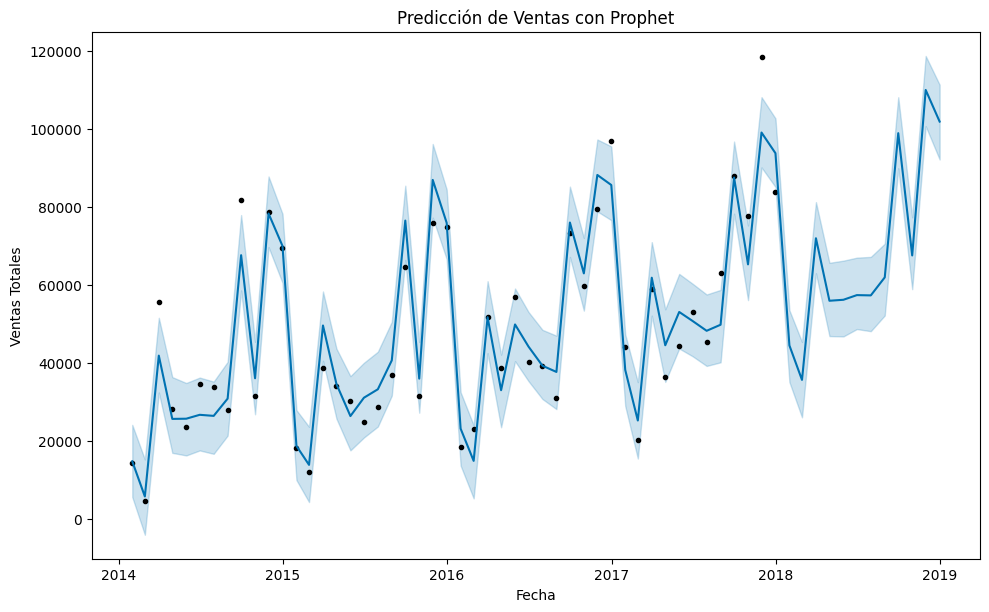

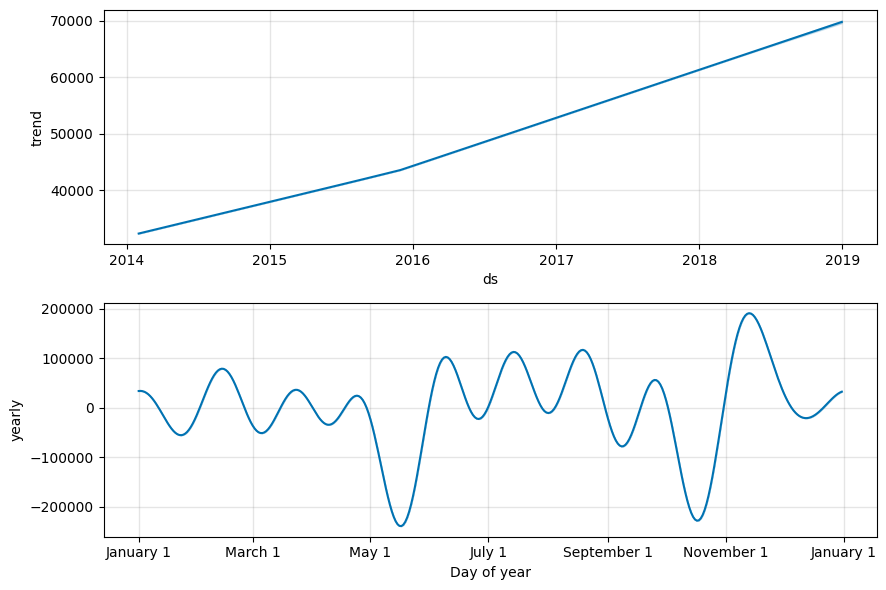

In [ ]:
# Implementar Prophet
# Crear y ajustar el modelo Prophet
# Crear y ajustar el modelo Prophet
model = Prophet()
model.fit(monthly_sales)

# Crear un marco de datos futuro para predicciones (12 meses hacia adelante)
future = model.make_future_dataframe(periods=12, freq='ME')  # Usar 'ME'
forecast = model.predict(future)

# Visualizar predicciones
model.plot(forecast)
plt.title("Predicción de Ventas con Prophet")
plt.xlabel("Fecha")
plt.ylabel("Ventas Totales")
plt.grid()
plt.show()

# Mostrar componentes de la predicción (tendencia y estacionalidad)
model.plot_components(forecast)
plt.show()

c:\Users\cafef\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


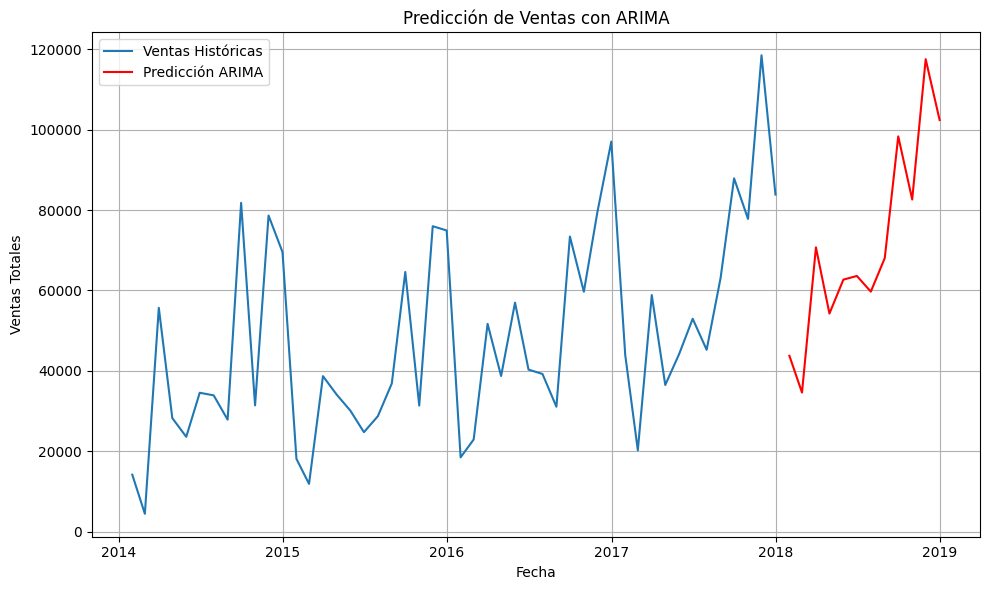

In [140]:
# Implementar ARIMA
# Asegurar que los datos tienen frecuencia definida
monthly_sales_arima = monthly_sales.set_index('ds')['y'].asfreq('ME')  # Definir explícitamente la frecuencia

# Crear y ajustar el modelo SARIMA
model_arima = SARIMAX(monthly_sales_arima, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
result_arima = model_arima.fit(disp=False)

# Predicciones
forecast_arima = result_arima.get_forecast(steps=12)
forecast_index = pd.date_range(start=monthly_sales_arima.index[-1] + pd.offsets.MonthEnd(1), periods=12, freq='ME')
forecast_values = forecast_arima.predicted_mean

# Visualizar predicciones
plt.figure(figsize=(10, 6))
plt.plot(monthly_sales_arima, label='Ventas Históricas')
plt.plot(forecast_index, forecast_values, label='Predicción ARIMA', color='red')
plt.title("Predicción de Ventas con ARIMA")
plt.xlabel("Fecha")
plt.ylabel("Ventas Totales")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


In [142]:
# Validación de Modelos: Prophet y ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

# División de datos en entrenamiento y prueba (últimos 12 meses para prueba)
train_data = monthly_sales[:-12]
test_data = monthly_sales[-12:]

# Prophet: Entrenamiento y predicción
model = Prophet()
model.fit(train_data)
future_test = model.make_future_dataframe(periods=12, freq='ME')
forecast_test = model.predict(future_test)
prophet_predictions = forecast_test.iloc[-12:]['yhat'].values

# ARIMA: Entrenamiento y predicción
monthly_sales_arima = train_data.set_index('ds')['y'].asfreq('ME')
model_arima = SARIMAX(monthly_sales_arima, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
result_arima = model_arima.fit(disp=False)
arima_predictions = result_arima.get_forecast(steps=12).predicted_mean.values

# Métricas de rendimiento
true_values = test_data['y'].values

prophet_mae = mean_absolute_error(true_values, prophet_predictions)
prophet_rmse = np.sqrt(mean_squared_error(true_values, prophet_predictions))

arima_mae = mean_absolute_error(true_values, arima_predictions)
arima_rmse = np.sqrt(mean_squared_error(true_values, arima_predictions))

# Resultados
print("Rendimiento de Prophet:")
print(f"MAE: {prophet_mae:.2f}, RMSE: {prophet_rmse:.2f}")

print("Rendimiento de ARIMA:")
print(f"MAE: {arima_mae:.2f}, RMSE: {arima_rmse:.2f}")

19:36:41 - cmdstanpy - INFO - Chain [1] start processing
19:36:41 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\cafef\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Rendimiento de Prophet:
MAE: 11648.94, RMSE: 15252.57
Rendimiento de ARIMA:
MAE: 17017.17, RMSE: 19683.78


Validación de Modelos: Interpretación de Resultados

1. Resultados de las Métricas

Prophet:

MAE (Mean Absolute Error): 11,648.94

RMSE (Root Mean Squared Error): 15,252.57

ARIMA:

MAE: 17,017.17

RMSE: 19,683.78

2. Análisis

Prophet tiene un desempeño mejor en ambas métricas (MAE y RMSE) comparado con ARIMA:

MAE mide el error promedio absoluto en las predicciones: Prophet tiene un error menor de alrededor de $11,648 comparado con los $17,017 de ARIMA.

RMSE penaliza los errores grandes más que el MAE: Prophet muestra un ajuste más preciso.

Advertencia sobre ARIMA:

El modelo ARIMA genera una advertencia sobre pocos datos para estimar los parámetros de la estacionalidad. Esto podría estar afectando su desempeño.

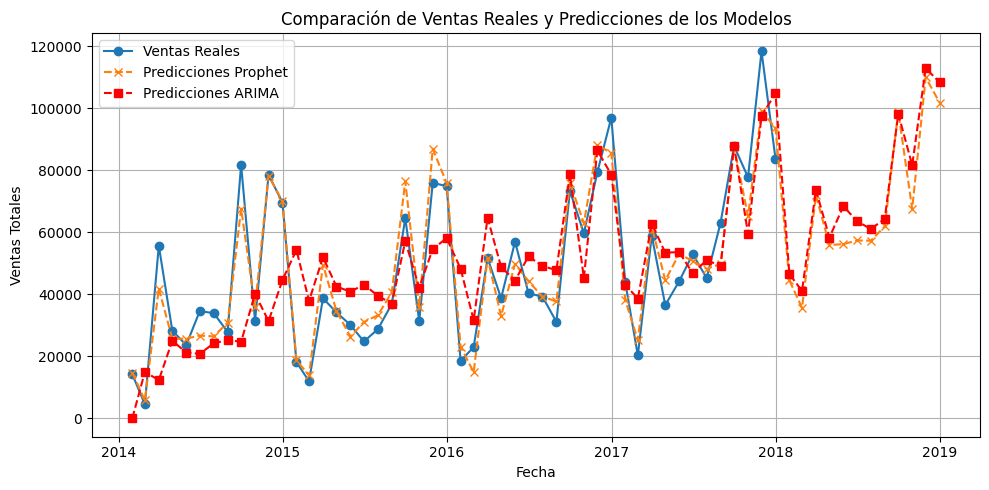

In [ ]:
# Predicciones dentro del rango histórico
in_sample_predictions = result_arima.get_prediction(start=monthly_sales_arima.index[0], end=monthly_sales_arima.index[-1])
in_sample_values = in_sample_predictions.predicted_mean

# Predicciones futuras
forecast_values = result_arima.get_forecast(steps=12).predicted_mean

# Combinar predicciones históricas y futuras en un único DataFrame
all_arima_predictions = pd.concat([
    pd.DataFrame({'Fecha': monthly_sales_arima.index, 'Ventas_Predichas_ARIMA': in_sample_values}),
    pd.DataFrame({'Fecha': pd.date_range(start=monthly_sales_arima.index[-1] + pd.offsets.MonthEnd(1), periods=12, freq='ME'),
                  'Ventas_Predichas_ARIMA': forecast_values})
], ignore_index=True)

# Unir las predicciones de ARIMA con las ventas reales y Prophet
predicciones = monthly_sales.merge(prophet_forecast, on='Fecha', how='outer')
predicciones = predicciones.merge(all_arima_predictions, on='Fecha', how='outer')

# Graficar los datos combinados
plt.figure(figsize=(10, 5))

# Ventas reales
plt.plot(predicciones['Fecha'], predicciones['Ventas_Reales'], label='Ventas Reales', marker='o')

# Predicciones Prophet
plt.plot(predicciones['Fecha'], predicciones['Ventas_Predichas_Prophet'], label='Predicciones Prophet', linestyle='--', marker='x')

# Predicciones ARIMA
plt.plot(predicciones['Fecha'], predicciones['Ventas_Predichas_ARIMA'], label='Predicciones ARIMA', linestyle='--', marker='s', color='red')

# Configuración del gráfico
plt.title("Comparación de Ventas Reales y Predicciones de los Modelos")
plt.xlabel("Fecha")
plt.ylabel("Ventas Totales")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [72]:
# Exportar resultados a CSV 
predicciones.to_csv("predicciones.csv", index=False) 
print("Archivo 'predicciones.csv' generado.")

Archivo 'predicciones.csv' generado.


In [84]:
# Asegurar que el DataFrame `df` contiene las columnas necesarias
# Agrupar los datos por ciudad y calcular métricas de interés
analisis_geografico = df.groupby('City').agg({
    'Sales': 'sum',
    'Profit': 'sum'
}).reset_index()

# Asegurar que las ciudades están relacionadas con un estado (o coordenadas) si es necesario
# Si necesitas coordenadas específicas, deberás agregarlas manualmente o mediante una API.

In [85]:
# Ejemplo para agregar coordenadas manualmente
# Diccionario con coordenadas de ejemplo (latitud, longitud)
ciudades_coordenadas = {
    "Los Angeles": (34.05, -118.25),
    "New York": (40.71, -74.00),
    "Chicago": (41.88, -87.63),
    "Houston": (29.76, -95.36),
    "Miami": (25.76, -80.19),
    # Agrega más ciudades según sea necesario
}

# Crear columnas de latitud y longitud basadas en el diccionario
analisis_geografico['lat'] = analisis_geografico['City'].map(lambda x: ciudades_coordenadas.get(x, (None, None))[0])
analisis_geografico['lon'] = analisis_geografico['City'].map(lambda x: ciudades_coordenadas.get(x, (None, None))[1])

# Filtrar ciudades con coordenadas válidas
analisis_geografico = analisis_geografico.dropna(subset=['lat', 'lon'])

# Crear un mapa interactivo con coordenadas geográficas
fig = px.scatter_geo(
    analisis_geografico,
    lat='lat',
    lon='lon',
    color='Profit',
    size='Sales',
    hover_name='City',
    title="Mapa Geográfico de Ganancias por Ciudad"
)
fig.show()

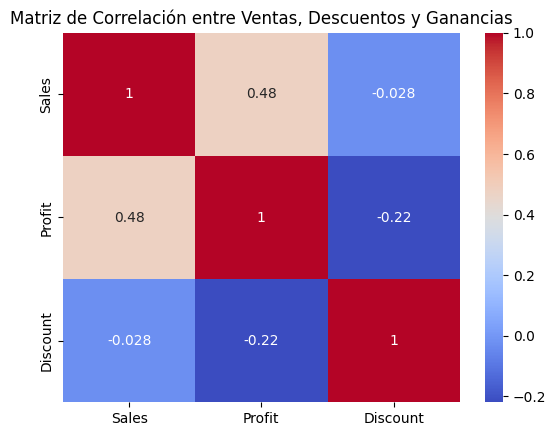

In [82]:
# Matriz de correlación entre ventas, ganancias y descuentos
correlacion = df[['Sales', 'Profit', 'Discount']].corr()
sns.heatmap(correlacion, annot=True, cmap="coolwarm")
plt.title("Matriz de Correlación entre Ventas, Descuentos y Ganancias")
plt.show()

In [81]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, root_mean_squared_error  # Importar RMSE directamente

# Preparación de datos
features = df[['Discount', 'Quantity', 'Profit']]  # Variables predictoras
target = df['Sales']  # Variable objetivo
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Entrenar modelo XGBoost
model = XGBRegressor(n_estimators=100, learning_rate=0.1)
model.fit(X_train, y_train)

# Predicciones
y_pred = model.predict(X_test)

# Evaluación
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)  # Usar RMSE directamente

print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}")

MAE: 118.77, RMSE: 596.62


In [76]:
from sklearn.model_selection import GridSearchCV

# Definir hiperparámetros para buscar
params = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

# Búsqueda de hiperparámetros
grid_search = GridSearchCV(estimator=XGBRegressor(), param_grid=params, scoring='neg_mean_squared_error', cv=3)
grid_search.fit(X_train, y_train)

print("Mejores parámetros:", grid_search.best_params_)

Mejores parámetros: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}


C:\Users\cafef\AppData\Local\Temp\ipykernel_30680\871443782.py:11: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.




DataFrame combinado después de completar valores faltantes para XGBoost:
        Fecha  Ventas_Reales  Ventas_Predichas_Prophet  \
55 2018-08-31            NaN                  61936.25   
56 2018-09-30            NaN                  98895.64   
57 2018-10-31            NaN                  67553.86   
58 2018-11-30            NaN                 109972.88   
59 2018-12-31            NaN                 101864.66   

    Ventas_Predichas_ARIMA  Ventas_Predichas_XGBoost  
55                64389.04                      0.00  
56                98270.10                      0.00  
57                81677.06                      0.00  
58               112907.84                      0.00  
59               108439.70                      0.00  


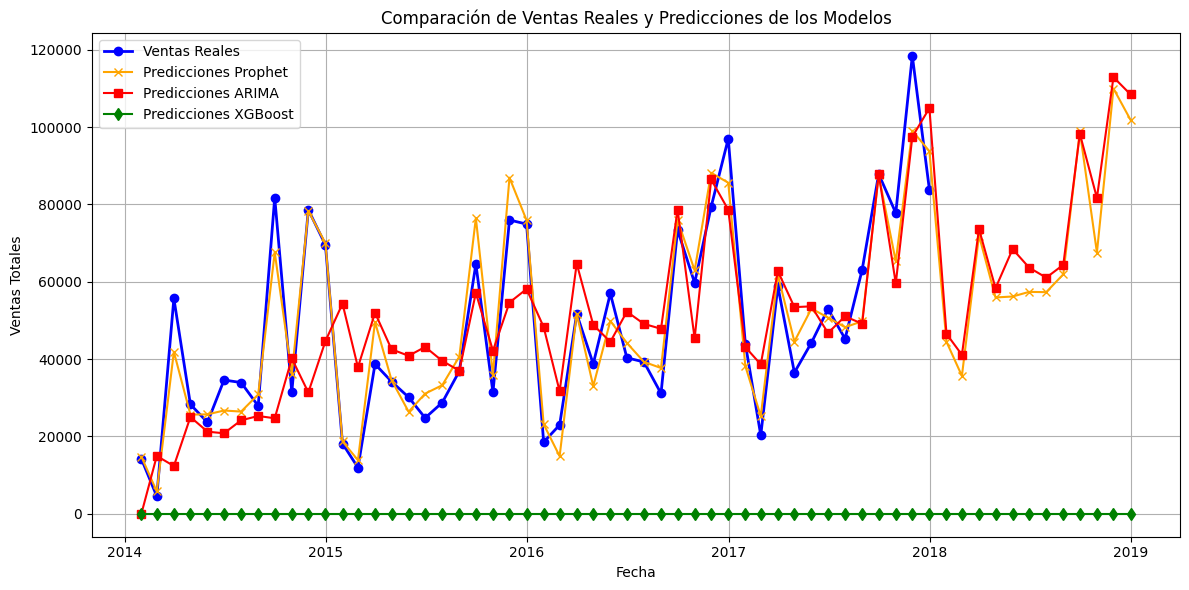

In [107]:
# Extender el rango de fechas con la frecuencia 'ME' para evitar advertencias
fecha_inicio = predicciones['Fecha'].min()
fecha_fin = predicciones['Fecha'].max()
todas_las_fechas = pd.date_range(fecha_inicio, fecha_fin, freq='ME')  # 'ME' es la frecuencia correcta

# Alinear las predicciones de XGBoost con las fechas
xgboost_monthly_full = pd.DataFrame({'Fecha': todas_las_fechas})
xgboost_monthly_full = xgboost_monthly_full.merge(xgboost_monthly, on='Fecha', how='left')

# Rellenar valores faltantes utilizando métodos sin advertencias
xgboost_monthly_full['Ventas_Predichas_XGBoost'] = xgboost_monthly_full['Ventas_Predichas_XGBoost'].fillna(method='ffill').fillna(0)

# Volver a combinar todas las predicciones con las series existentes
predicciones = monthly_sales.merge(prophet_forecast, on='Fecha', how='outer')
predicciones = predicciones.merge(all_arima_predictions, on='Fecha', how='outer')
predicciones = predicciones.merge(xgboost_monthly_full, on='Fecha', how='outer')

# Asegurarnos de que no haya duplicados y ordenar por fecha
predicciones = predicciones.drop_duplicates(subset=['Fecha']).sort_values(by='Fecha')

# Verificar el DataFrame combinado después de completar los valores
print("\nDataFrame combinado después de completar valores faltantes para XGBoost:")
print(predicciones.tail())

# Graficar los datos combinados
plt.figure(figsize=(12, 6))

# Ventas reales
if 'Ventas_Reales' in predicciones.columns:
    plt.plot(
        predicciones['Fecha'], predicciones['Ventas_Reales'],
        label='Ventas Reales', marker='o', linewidth=2, color='blue'
    )

# Predicciones Prophet
if 'Ventas_Predichas_Prophet' in predicciones.columns:
    plt.plot(
        predicciones['Fecha'], predicciones['Ventas_Predichas_Prophet'],
        label='Predicciones Prophet', linestyle='-', marker='x', linewidth=1.5, color='orange'
    )

# Predicciones ARIMA
if 'Ventas_Predichas_ARIMA' in predicciones.columns:
    plt.plot(
        predicciones['Fecha'], predicciones['Ventas_Predichas_ARIMA'],
        label='Predicciones ARIMA', linestyle='-', marker='s', linewidth=1.5, color='red'
    )

# Predicciones XGBoost
if 'Ventas_Predichas_XGBoost' in predicciones.columns:
    plt.plot(
        predicciones['Fecha'], predicciones['Ventas_Predichas_XGBoost'],
        label='Predicciones XGBoost', linestyle='-', marker='d', linewidth=1.5, color='green'
    )

# Configuración del gráfico
plt.title("Comparación de Ventas Reales y Predicciones de los Modelos")
plt.xlabel("Fecha")
plt.ylabel("Ventas Totales")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()